In [7]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
from scipy.stats import sem
import matplotlib.cm as cm
import pathlib
import traceback
import gc
import re
import configs

from data.ValidationDataset import NoisyDataset

# Parameters

In [69]:
model = 'pnet_noisy'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
pca_dir = f'{engram_dir}4_validation_pca/'
pickles_dir = f'{engram_dir}pickles/'
bg_types = ['pinkNoise', 'AudScene', 'Babble8Spkr']
snr_types = [-9, -6, -3, 0, 3]

In [70]:
recalc = False

# Helper Functions

In [71]:
def get_participation_ratio(pca):
    eigvals = pca.explained_variance_
    numerator = np.square(np.sum(eigvals))
    denominator = np.sum(np.square(eigvals))
    return numerator/denominator

# Load PCA models

In [72]:
def find_model_directories(directory_path, model):
    all_files_dirs = os.listdir(directory_path)
    pattern = f'\\b{model}(\\d*)\\b'  # Using word boundaries to ensure complete matches
    matches = [re.search(pattern, item) for item in all_files_dirs]
    
    # Filter out None values (i.e., items that didn't match) and return a list of tuples
    return [(match.group(0), int(match.group(1)) if match.group(1) else None) for match in matches if match]

In [73]:
def get_file_info(s):
    pattern = r"conv(\d+)_t(\d+)_seed(\d+)"
    match = re.search(pattern, s)
    if match:
        conv_int = int(match.group(1))
        t_int = int(match.group(2))
        seed_int = int(match.group(3))
        return conv_int, t_int, seed_int
    else:
        return None, None, None

In [74]:
model_directories = find_model_directories(pca_dir, model)

In [75]:
pickle_results_filename = f'{pickles_dir}{model}_pca_dimensionality.p'
if recalc:
    results = {
        'model': [],
        'bg': [],
        'snr': [],
        'participation ratio': [],
        'layer': [],
        'timestep': [],
        'seed': []
        }
    for model_dir, _iter in model_directories:
        model_dir = os.path.join(pca_dir, model_dir)
        for bg in bg_types:
            for snr in snr_types:
                noise_dir = os.path.join(model_dir, f'{bg}_snr{snr}')
                for pca_file in os.listdir(noise_dir):
                    conv_int, t_int, seed_int = get_file_info(pca_file)
                    pca_file = os.path.join(noise_dir, pca_file)
                    with open(pca_file, 'rb') as f:
                        pca = pickle.load(f)
                    pr = get_participation_ratio(pca)
                    results['model'].append(model)
                    results['bg'].append(bg)
                    results['snr'].append(snr)
                    results['participation ratio'].append(pr)
                    results['layer'].append(conv_int)
                    results['timestep'].append(t_int)
                    results['seed'].append(seed_int)
    with open(pickle_results_filename, 'wb') as f:
        pickle.dump(results, f)
else:
    with open(pickle_results_filename, 'rb') as f:
        results = pickle.load(f)

In [76]:
df = pd.DataFrame(results)

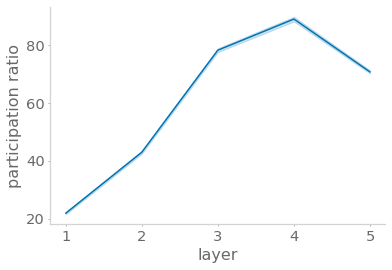

In [77]:
fig, ax = plt.subplots()
sns.lineplot(
    y='participation ratio', x='layer', data=df[df['timestep']==0],
    ax=ax)
plt.show()

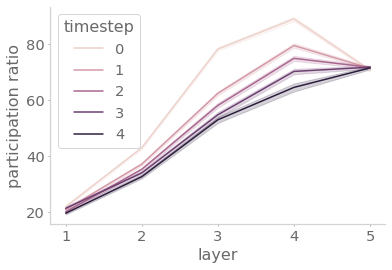

In [78]:
fig, ax = plt.subplots()
sns.lineplot(
    y='participation ratio', x='layer', data=df,
    hue='timestep',
    ax=ax)
plt.show()

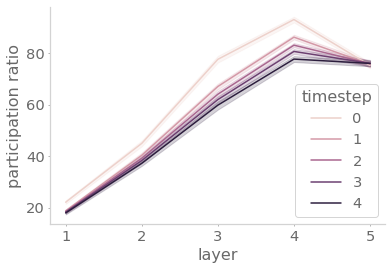

In [79]:
fig, ax = plt.subplots()
sns.lineplot(
    y='participation ratio', x='layer', data=df[df['snr']==3],
    hue='timestep',
    ax=ax)
plt.show()

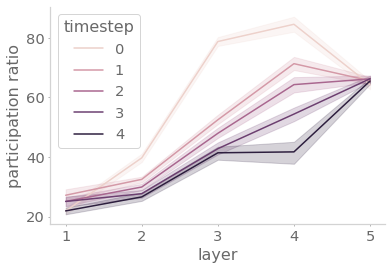

In [80]:
fig, ax = plt.subplots()
sns.lineplot(
    y='participation ratio', x='layer', data=df[df['snr']==-9],
    hue='timestep',
    ax=ax)
plt.show()